Straight-forward mapping the verilog benchmarks to the required format

In [1]:
import re
import os
import numpy as np

In [2]:
def map_idx_to_id(idx, all_idx):
    for i in range(len(all_idx)):
        if idx == all_idx[i]:
            return i
    return -1

def map_idxs_to_ids(idxs, all_idx):
    ids = []
    for idx in idxs:
        ids.append(map_idx_to_id(idx, all_idx))
    return ids

In [40]:
def find_neighbors(all_idx, signal, wire_id = 0):
    """finds neighbors of 'signal' node in 'all_idx' graph, assiming that wire relation is 'wire_id' 
    """
    frontier = [signal]
    neighbors = []
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        for (e1,r,e2) in all_idx:
            if e1 == current[2]:
                if r == wire_id:
                    frontier.append((e1,r,e2))
                else:
                    neighbors.append([e1,r,e2])
            if e2 == current[0]:
                if r == wire_id:
                    frontier.append((e1,r,e2))
                else:
                    neighbors.append([e1,r,e2])
    return neighbors
    

In [38]:
def extract_input_output_pairs_trojan(filename):
    """
    idx - graph elements, 3-tuples like (100,10,100). Each of them stand for one embedding
    """
    original_v = ''
    with open(filename, 'rt') as f:
        original_v = f.read()
    
    signal_lists = []
    
    trojan_signals = []
    safe_signals = []
    triggering_events_signals = []
    
    first_order_triggering_events = []
    
    trojan_gate_name = r'.*troj.*'
    
    output_strings = []
    
    entities_set = set()
    relations_set = set()
    
    safe_ids = []
    trojan_ids = []
    
    matches = re.findall(r'\n\s*([A-Za-z0-9_]+)\s+([A-Za-z0-9_]+)\s*\((.*)\).*;', original_v)
    for m in matches:
        #print(m[1])
        gate_type = m[0]
        gate_name = m[1]
        signal_list = re.split(r'[\s\(\),]+', m[2])
        signal_list = list(filter(lambda x: len(x) > 0, signal_list))
        input_list = signal_list[::2]
        signal_list = signal_list[1::2]
        
        relations = list([gate_type + x for x in input_list])
        
        #print(signal_list)
        gate_output = signal_list[0]
        signal_list = signal_list[1:]
        
        tab = '\t'
        
        for signal, relation in zip(signal_list, relations):
            output_string = f"{gate_name}{tab}{relation}{tab}{signal}\n"
            output_strings.append(output_string)
            
            entities_set.add(gate_name)
            entities_set.add(signal)
            relations_set.add(relation)
            
            #if bool(signal.find('troj') != -1) != bool(gate_name.find('troj') != -1):
            #    first_order_triggering_events.append((gate_name, relation, signal))
            
            if re.match(trojan_gate_name, gate_name):
                trojan_signals.append((gate_name, relation, signal))
                #triggering_events_signals.append()
            else:
                #if signal.find('troj') != -1:
                #if re.match(trojan_gate_name, signal):
                 #   print('Event!')
                 #   first_order_triggering_events.append((gate_name, relation, signal))
                safe_signals.append((gate_name, relation, signal))
                
        
        if bool(gate_output.find('troj') != -1) != bool(gate_name.find('troj') != -1):
                first_order_triggering_events.append((gate_name, relation, signal))
        
        output_strings.append(f"{gate_output}{tab}wire{tab}{gate_name}\n")
        if re.match(trojan_gate_name, gate_name):
            trojan_signals.append((gate_output, 'wire', gate_name))
        else:
            safe_signals.append((gate_output, 'wire', gate_name))
        entities_set.add(gate_name)
        entities_set.add(gate_output)
        relations_set.add('wire')
        
    entities_to_id = {x: i for (i, x) in enumerate(sorted(entities_set))}
    relations_to_id = {x: i for (i, x) in enumerate(sorted(relations_set))}
    
    wire_id = relations_to_id['wire']
    
    trojan_signals_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in trojan_signals]
    safe_signals_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in safe_signals]
    first_order_idx = [[entities_to_id[e1], relations_to_id[r], entities_to_id[e2]] for (e1, r, e2) in first_order_triggering_events]
    
   
    
    def test(safe):
        #if safe[0]
        print(safe)
        return False
        #return safe[0] == e1
    
    # list(filter(lambda (safe_e1, safe_r, safe_e2): safe_e1 == e2 , safe-signals_idx))  
    #triggering_events_idx = [ list( filter((lambda safe: safe[0] == e2), safe_signals_idx) ) for (e1,r,e2) in trojan_signals_idx]
    join = [(trojan[2], safe[0], safe[1], safe[2]) for safe in safe_signals_idx for trojan in trojan_signals_idx if safe[2] == trojan[0]]
    #triggering_events_idx = [ list( filter(test, safe_signals_idx) ) for (e1,r,e2) in trojan_signals_idx]
    
    #print(trojan_signals_idx)
    #print('triggering events')
    #print(first_order_idx)
    #print(join)
    
#     for i in safe_signals_idx:
#         if i[0] == 185:
#             print(i)
    
#     #changing wire_id to zero for convenience
#     for i in range(len(trojan_signals_idx)):
#         if trojan_signals_idx[1] == wire_id:
#             trojan_signals_idx[1] = 0
#         elif trojan_signals_idx[1] == 0:
#             trojan_signals_idx[1] = wire_id
#     for i in range(len(safe_signals_idx)):
#         if safe_signals_idx[1] == wire_id:
#             safe_signals_idx[1] = 0
#         elif safe_signals_idx[1] == 0:
#             safe_signals_idx[1] = wire_id
#     for i in range(len(first_order_idx)):
#         if first_order_idx[1] == wire_id:
#             first_order_idx[1] = 0
#         elif first_order_idx[1] == 0:
#             first_order_idx[1] = wire_id
#     wire_id = 0
    
    all_idx = safe_signals_idx + trojan_signals_idx
    
    neighbors = []
    for i in first_order_idx:
        neighbors.append(find_neighbors(all_idx, i, wire_id))
    
    neighbors_ids = []
    for n in neighbors:
        neighbors_ids.append( [i for i in range(len(all_idx)) if all_idx[i] in n] )
    
    print('neighbors:', neighbors)
    print('neighbors ids:', neighbors_ids)
    
    first_order_ids = [i for i in range(len(all_idx)) if all_idx[i] in first_order_idx]
    
    
    
    with open('./all_idx.txt', 'w') as f:
        for item in all_idx:
            f.write("%s\n" % item)
    
    #print(len(safe_signals_idx), len(trojan_signals_idx))
        
    return output_strings, all_idx, safe_signals_idx, trojan_signals_idx, first_order_ids, neighbors_ids, wire_id

In [5]:
def train_netlist_embeddings(filename, num_epochs = 30):
    """ trains embeddings from the given file
    """
    strings, all_idx, safe_idx, trojan_idx, first_order_ids, neighbors_ids, wire_id = extract_input_output_pairs_trojan(filename)
    from kbc import process_datasets
    
    from kbc.datasets import Dataset
    from kbc.models import CP, ComplEx
    from kbc.regularizers import F2, N3
    from kbc.optimizers import KBCOptimizer
    from kbc.process_datasets import prepare_dataset
    
    from pathlib import Path
    import pkg_resources
    
    import shutil


    
    import torch
    from torch import optim

    import tqdm
    
    if not os.path.exists('./tmp'):
        os.makedirs('./tmp')
    
    with open('./tmp/train', 'wt') as f:
            f.writelines(strings)
    with open('./tmp/valid', 'wt') as f:
            f.writelines(strings)
    with open('./tmp/test', 'wt') as f:
            f.writelines(strings)
    
    
    DATA_PATH = pkg_resources.resource_filename('kbc', 'data/')
    if os.path.exists(Path(DATA_PATH) / filename):
        shutil.rmtree(Path(DATA_PATH) / filename)
        
    
    prepare_dataset('./tmp/', filename)
    
    
    dataset = Dataset(filename)
   
    model = ComplEx(dataset.get_shape(), 200)
    
    device = 'cuda'
    model.to(device)
    
    regularizer = N3(0.00001)
    examples = torch.from_numpy(dataset.get_train().astype('int64'))
    
    optimizer = KBCOptimizer(model, regularizer, optim.Adagrad(model.parameters(), lr=0.1), batch_size=256, verbose = False)

    
    
    cur_loss = 0
    curve = {'train': [], 'valid': [], 'test': []}

    for e in tqdm.tqdm (range(num_epochs)):
        cur_loss = optimizer.epoch(examples)
    
    print(len(all_idx))
    embeddings = model.get_queries(torch.tensor(all_idx).to("cuda"))
    embeddings = embeddings.cpu().detach().numpy()
    return embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx


In [6]:
def draw_embeddings(embeddings, mask = []):
    """ projects multi-dim embeddings into 2d and draw them. Works slowly
    returns 2d projection of embeddings
    args: embeddings - np array of multidim embeddings, mask - indices of embeddings to be shown in different color 
    """
    import numpy as np
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1000)
    lowdim = tsne.fit_transform(embeddings)
    
    masked = lowdim[mask]
    print(masked)
    
    plt.scatter(lowdim.transpose()[0], lowdim.transpose()[1])
    plt.scatter(masked.transpose()[0], masked.transpose()[1], color = 'orange')
    plt.show()
    
    return lowdim

In [7]:
def draw_highlighted(embeddings_low_dim, mask = []):
    """ draws 2d projected embedding
    args: embeddings_low_dim - 2d embeddings, mask - indices of embeddings to be shown in different color 
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    masked = embeddings_low_dim[mask,:]
    print(embeddings_low_dim.shape[0], "is the number of highlighed points.")
    
    plt.scatter(embeddings_low_dim.transpose()[0], embeddings_low_dim.transpose()[1])
    plt.scatter(masked.transpose()[0], masked.transpose()[1], color = 'orange')
    plt.show()    

In [8]:
arr = np.array([[1,1,1],[2,2,2]])
vec = np.array([1,1,1])
np.square(arr - vec)
ls = np.sqrt(np.sum(np.square(arr - vec), axis = 1))
mean = np.mean(ls)
mean


0.8660254037844386

In [9]:
def measure_metrics(node, neighbors):
    #neighbours = embeddings[neighbor_mask]
    lengthes = np.sqrt(np.sum(np.square(neighbors - node), axis = 1)) 
    mean = np.mean(lengthes)
    median = np.median(lengthes)
    maximum = np.max(lengthes)
    minimum = np.min(lengthes)
    
    return mean, median, maximum, minimum

In [10]:
import random

def sample_safe_with_neighbors(all_idx, safe_idx, n_samples, wire_id):
    """
    returns ids (numerical index in array of all_idx) of n_samples random samples of safe_idx (3-tuples). all_idx - graph in form of 3-tuples 
    """
    safes_sampled_idx = []
    for i in range(n_samples):
        rand_index = random.randint(0, len(safe_idx))
        safes_sampled_idx.append(safe_idx[rand_index])
        
    neighbors = []
    for i in safes_sampled_idx:
        neighbors.append(find_neighbors(all_idx, i, wire_id))

    neighbors_ids = []
    for n in neighbors:
        neighbors_ids.append( [i for i in range(len(all_idx)) if all_idx[i] in n] )

    safe_ids = [i for i in range(len(all_idx)) if all_idx[i] in safes_sampled_idx]
    
    return safe_ids, neighbors_ids

In [11]:
def get_location_of_embeddings(embeddings_ids, embeddings):
    import numpy as np
    #print("embeddings_shape = ",embeddings.shape)
    #print(embeddings_ids)
    target_embeddings = embeddings[embeddings_ids,:]
    mean = np.mean(target_embeddings, axis = 0)
    std = np.std(target_embeddings, axis = 0)
    return mean, std

def filter_embeddings_in_range(embeddings, mask, center, radii):
    """takes embeddings, return indices of embeddings with range radii from coordinates center
    args: embeddings - array of all embeddings, mask - only embeddings with indices in array 'mask' are considered,
    center - centor position, radii - radii 
    """
    #filtered_mask = np.where(center - embeddings[mask,:] < radii, mask)
    filtered_mask = list(filter(lambda x: (np.abs(center - embeddings[x]) < radii).all(), mask))
    print(len(filtered_mask))
    print(filtered_mask)
    return filtered_mask
    
# embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v')
# mean, std = get_location_of_embeddings(first_order_ids, embeddings)
# print(std)
# filter_embeddings_in_range(embeddings, list(range(0, embeddings.shape[0] - 25)), mean, 0.6)

In [12]:
def trojan_metric(node_embedding, neighbors_embeddings):
    """ Measures multi-dimensional "standard deviation" and distance from main cluster of neighbors to outlier
    args: node_embedding - not used (lol)
    neighbors_embedding - np array of size axb, a - # of neighbors, b - # of embedding dimensions
    """
    
    #calculating the geometric center
    center = np.mean(neighbors_embeddings, axis = 0)
    #print(center.shape)
    #looking for the furthest point
    
    # shame
    #dist = np.vectorize(lambda a, b: np.sqrt(np.sum(np.square(a-b))))
    #distances = dist(neighbors_embeddings, center)
    distances = []
    for i in range(neighbors_embeddings.shape[0]):
        neigh = neighbors_embeddings[i]
        distances.append(np.sqrt(np.sum(np.square(neigh-center))))
    distances = np.array(distances)    
    
    
    #print(distances.shape)
    outlier_index = np.argmax(distances)
    outlier = neighbors_embeddings[outlier_index]
    cluster_center = np.mean(np.delete(neighbors_embeddings, np.s_[outlier_index], axis = 0), axis = 0)
    distance_to_outlier = np.sqrt(np.sum(np.square(cluster_center-outlier)))
    
    distances_to_cluster_center = []
    for i in range(neighbors_embeddings.shape[0]):
        neigh = neighbors_embeddings[i]
        distances_to_cluster_center.append(np.sqrt(np.sum(np.square(neigh-cluster_center))))
    distances_to_cluster_center = np.array(distances_to_cluster_center)    
    
    cluster_std = np.mean(np.delete(distances_to_cluster_center, np.s_[outlier_index], axis = 0), axis = 0)
    #print(cluster_std)
    
    return cluster_std, distance_to_outlier
    
    

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

neighbors: [[[673, 8, 1484], [1530, 4, 1462], [1530, 5, 1448], [1530, 6, 1416], [1530, 7, 1537]], [[470, 8, 1413], [1531, 4, 1049], [1531, 5, 931], [1531, 6, 1538], [1531, 7, 1536]], [[705, 2, 973], [1532, 1, 1538]], [[1529, 10, 1536], [1529, 11, 1537], [1529, 12, 205], [1533, 17, 1535], [371, 9, 1094], [1533, 13, 985], [1533, 14, 1103], [1533, 15, 1102], [1533, 16, 1539], [1533, 17, 1535]], [[807, 0, 1499], [1534, 13, 1337], [1534, 14, 1311], [1534, 15, 1171], [1534, 16, 1139], [1534, 17, 1539]], [[1540, 19, 205], [1540, 20, 1293]]]
neighbors ids: [[1488, 1940, 1941, 1942, 1943], [956, 1945, 1946, 1947, 1948], [144, 1950], [702, 1936, 1937, 1938, 1952, 1953, 1954, 1955, 1956], [1842, 1958, 1959, 1960, 1961, 1962], [1964, 1965]]
1541 entities and 21 relations
creating filtering lists


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.22it/s]


1967
Trojans:


E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


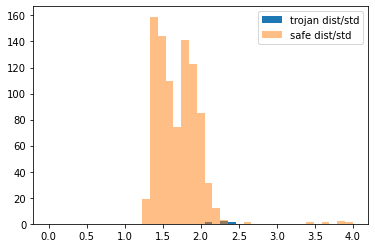

In [26]:
#experiment - drawing histogram of our new metric for trojan nodes
import random
import matplotlib.pyplot as plt


embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v', 100)
mean, std = get_location_of_embeddings(first_order_ids, embeddings)
print('Trojans:')

trojan_metrics = []

for n, neighs in zip(first_order_ids, neighbors_ids):
    if len(neighs) > 1:
        #std, dist = trojan_metric(n, embeddings[neighs,:] + [n])
        std, dist = trojan_metric(n, embeddings[neighs,:])
        trojan_metrics.append(dist/(std+0.000001))
        
# bins = np.linspace(0, 10, 100)
# plt.hist(trojan_metrics, bins, alpha=0.5, label='trojan dist/std')
# #plt.hist(y, bins, alpha=0.5, label='y')
# plt.legend(loc='upper right')
# plt.show()

#sampling safe nodes
safe_metrics = []
safe_ids = map_idxs_to_ids(safe_idx , all_idx)
for safe_id in safe_ids:
    #sampling
    sampling_rate = 0.5
    if random.uniform(0, 1) > sampling_rate: continue 
    if len(neighs) > 1:
        safe_neighbors = find_neighbors(all_idx, all_idx[safe_id], wire_id)
        safe_neighbors = map_idxs_to_ids(safe_neighbors, all_idx)
        # std, dist = trojan_metric(safe_id, embeddings[safe_neighbors,:] + [n])
        std, dist = trojan_metric(safe_id, embeddings[safe_neighbors,:])
        safe_metrics.append(dist/(std+0.000001))

bins = np.linspace(0, 4, 40)
plt.hist(trojan_metrics, bins, alpha=1, label='trojan dist/std')
plt.hist(safe_metrics, bins, alpha=0.5, label='safe dist/std')
#plt.hist(y, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

neighbors: [[[673, 8, 1484], [1530, 4, 1462], [1530, 5, 1448], [1530, 6, 1416], [1530, 7, 1537]], [[470, 8, 1413], [1531, 4, 1049], [1531, 5, 931], [1531, 6, 1538], [1531, 7, 1536]], [[705, 2, 973], [1532, 1, 1538]], [[1529, 10, 1536], [1529, 11, 1537], [1529, 12, 205], [1533, 17, 1535], [371, 9, 1094], [1533, 13, 985], [1533, 14, 1103], [1533, 15, 1102], [1533, 16, 1539], [1533, 17, 1535]], [[807, 0, 1499], [1534, 13, 1337], [1534, 14, 1311], [1534, 15, 1171], [1534, 16, 1139], [1534, 17, 1539]], [[1540, 19, 205], [1540, 20, 1293]]]
neighbors ids: [[1488, 1940, 1941, 1942, 1943], [956, 1945, 1946, 1947, 1948], [144, 1950], [702, 1936, 1937, 1938, 1952, 1953, 1954, 1955, 1956], [1842, 1958, 1959, 1960, 1961, 1962], [1964, 1965]]
1541 entities and 21 relations
creating filtering lists


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.02it/s]


1967
[[[-1.1757648   0.31967473]
  [-1.0300647   0.14784524]
  [-0.38721454  0.4779507 ]
  ...
  [ 0.00800874  0.20159933]
  [ 0.01753427  0.15314576]
  [-0.00970748  0.21768482]]]


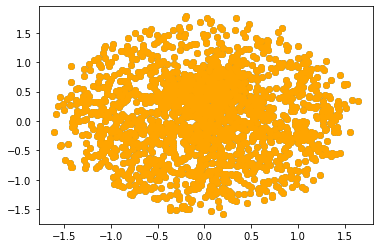

Trojans:


E:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


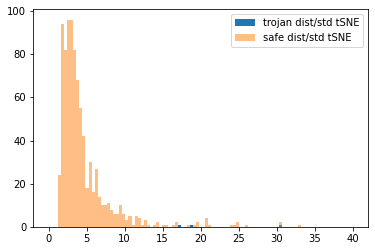

In [52]:
#experiment - drawing histogram of our new metric for BOTH trojan and safe in tSNE projection
import random


embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v',100)
mean, std = get_location_of_embeddings(first_order_ids, embeddings)

embeddings_low_dim = draw_embeddings(embeddings, None)

print('Trojans:')

# and same thing , but with tSNE projection

trojan_metrics = []

for n, neighs in zip(first_order_ids, neighbors_ids):
    if len(neighs) > 1:
        std, dist = trojan_metric(n, embeddings_low_dim[neighs,:])
        trojan_metrics.append(dist/(std+0.000001))
        
# bins = np.linspace(0, 10, 100)
# plt.hist(trojan_metrics, bins, alpha=0.5, label='trojan dist/std')
# #plt.hist(y, bins, alpha=0.5, label='y')
# plt.legend(loc='upper right')
# plt.show()

#sampling safe nodes
safe_metrics = []
safe_ids = map_idxs_to_ids(safe_idx , all_idx)
for safe_id in safe_ids:
    #sampling
    sampling_rate = 0.5
    if random.uniform(0, 1) > sampling_rate: continue 
    safe_neighbors = find_neighbors(all_idx, all_idx[safe_id], wire_id)
    safe_neighbors = map_idxs_to_ids(safe_neighbors, all_idx)
    std, dist = trojan_metric(safe_id, embeddings_low_dim[safe_neighbors,:])
    safe_metrics.append(dist/(std+0.000001))

bins = np.linspace(0, 40, 100)
plt.hist(trojan_metrics, bins, alpha=1, label='trojan dist/std tSNE')
plt.hist(safe_metrics, bins, alpha=0.5, label='safe dist/std tSNE')
#plt.hist(y, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

Approximately the same number of safe nodes have metric more than trojan for both tSNE projection and no projection.

Next steps:
  
-- visualise safe ones with high metric value to eyeball them

-- check if they are by chance neighbors of trojan nodes, mark them with different color, mark triggering events with a color

-- ??? mesaure the distance (in # of gates) from bad safe nodes to trojan nodes

-- filter embeddings in the centermost cluster to combine policy from the previous research and this one

-- ??? rewrite 

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

neighbors: [[[673, 8, 1484], [1530, 4, 1462], [1530, 5, 1448], [1530, 6, 1416], [1530, 7, 1537]], [[470, 8, 1413], [1531, 4, 1049], [1531, 5, 931], [1531, 6, 1538], [1531, 7, 1536]], [[705, 2, 973], [1532, 1, 1538]], [[1529, 10, 1536], [1529, 11, 1537], [1529, 12, 205], [1533, 17, 1535], [371, 9, 1094], [1533, 13, 985], [1533, 14, 1103], [1533, 15, 1102], [1533, 16, 1539], [1533, 17, 1535]], [[807, 0, 1499], [1534, 13, 1337], [1534, 14, 1311], [1534, 15, 1171], [1534, 16, 1139], [1534, 17, 1539]], [[1540, 19, 205], [1540, 20, 1293]]]
neighbors ids: [[1488, 1940, 1941, 1942, 1943], [956, 1945, 1946, 1947, 1948], [144, 1950], [702, 1936, 1937, 1938, 1952, 1953, 1954, 1955, 1956], [1842, 1958, 1959, 1960, 1961, 1962], [1964, 1965]]
1541 entities and 21 relations
creating filtering lists


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.93it/s]


1967
[2.4120199311932673, 2.537553840993146, 6633716.106414795, 2.2493516697801708, 2.0676286769821193, 3022960.1860046387]
threshold is  1.0
[]


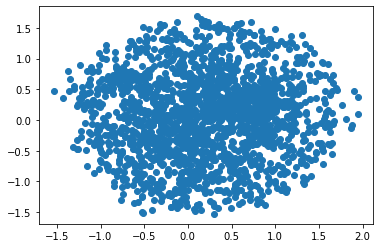

trojan list length =  31


E:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
E:\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [53]:
# experiment - visualise bad safe ones



embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v', 100)
mean, std = get_location_of_embeddings(first_order_ids, embeddings)



trojan_metrics = []

for n, neighs in zip(first_order_ids, neighbors_ids):
    if len(neighs) > 1:
        std, dist = trojan_metric(n, embeddings[neighs,:] )
        trojan_metrics.append(dist/(std+0.000001))

print(trojan_metrics)
        
    
#threshold = np.max(trojan_metrics)
threshold = 1.0
print('threshold is ', threshold)

low_dim = draw_embeddings(embeddings)

# bins = np.linspace(0, 10, 100)
# plt.hist(trojan_metrics, bins, alpha=0.5, label='trojan dist/std')
# #plt.hist(y, bins, alpha=0.5, label='y')
# plt.legend(loc='upper right')
# plt.show()

all_idx = [(x[0], x[1], x[2]) for x in all_idx]
safe_idx = [(x[0], x[1], x[2]) for x in safe_idx]

trojan_idx = list(set(all_idx) - set(safe_idx))

print('trojan list length = ', len(trojan_idx))
trojan_ids =  map_idxs_to_ids(trojan_idx, all_idx)

bad_safes = []
bad_safes_neighbors = []
bad_safes_metrics = []
bad_have_trojan_neighbors = []

#sampling safe nodes
safe_metrics = []
safe_ids = map_idxs_to_ids(safe_idx , all_idx)
for safe_id in safe_ids:
    #sampling
    sampling_rate = 0.5
    if random.uniform(0, 1) > sampling_rate: continue 
    safe_neighbors = find_neighbors(all_idx, all_idx[safe_id], wire_id)
    safe_neighbors = map_idxs_to_ids(safe_neighbors, all_idx)
    std, dist = trojan_metric(safe_id, embeddings[safe_neighbors,:])
    safe_metrics.append(dist/(std+0.000001))
    if dist/(std+0.000001) > threshold:
        flag = False
        bad_safes.append(safe_id)
        bad_safes_neighbors.append(safe_neighbors)
        bad_safes_metrics.append(dist/(std+0.000001))
        for n in safe_neighbors:
            if n in trojan_ids:
                flag = True
        bad_have_trojan_neighbors.append(flag)
        
#print ("# of good ")        
        
for s, neigh, metric, trojan_neigh in zip(bad_safes, bad_safes_neighbors, bad_safes_metrics, bad_have_trojan_neighbors):
    print('Here is a safe node, metric is ', metric, ', and has it trojan neighbor?', trojan_neigh)
    draw_highlighted(low_dim, [s] + safe_neighbors)
    



In [ ]:
#experiment - visualize neighbors of SAFE nodes
embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v')

mean, std = get_location_of_embeddings(first_order_ids, embeddings)
#print(std)
filtered_safe = filter_embeddings_in_range(embeddings, list(range(0, embeddings.shape[0] - 50)), mean, 0.6)
low_dim = draw_embeddings(embeddings, filtered_safe)
print(low_dim.shape)
for i in filtered_safe:
    safe_neighbors = find_neighbors(all_idx, all_idx[i], wire_id)
    draw_highlighted(low_dim, map_idxs_to_ids(safe_neighbors, all_idx))

In [ ]:
#experiment - visualize neighbors of TROJAN nodes
embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v')
print(neighbors_ids)
print('HT embeddings, connected to safe hardware:')
draw_embeddings(embeddings, first_order_ids)

for n in neighbors_ids:
    draw_embeddings(embeddings, n)

#strings = extract_input_output_pairs_trojan('benches/c2670_T001.v')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

embeddings, first_order_ids, neighbors_ids, wire_id, all_idx, safe_idx = train_netlist_embeddings('benches/c2670_T001.v')
print(neighbors_ids)
print('HT embeddings, connected to safe hardware:')
low_dim = draw_embeddings(embeddings, first_order_ids)

# for troj, n in zip(first_order_ids,neighbors_ids):    
#     draw_highlighted(low_dim, n)

safes, safe_neighbors = sample_safe_with_neighbors(all_idx, safe_idx, 50, wire_id)
# print(safes)
# print(safe_neighbors)

for safe, n in zip(safes, safe_neighbors):    
     draw_highlighted(low_dim, n)

trojan_means = []
trojan_median = []
trojan_max = []
trojan_min = []

safe_means = []
safe_median = []
safe_max = []
safe_min = []

for node, neighbors in zip (first_order_ids, neighbors_ids):
    #print(neighbors_ids)
    mean, median, maximum, minimum = measure_metrics(embeddings[node], [embeddings[neighbors]])
    trojan_means.append(mean)
    trojan_median.append(mean)
    trojan_max.append(maximum)
    trojan_min.append(minimum)
    
for node, neighbors in zip (safes, safe_neighbors):
    #print(neighbors_ids)
    mean, median, maximum, minimum = measure_metrics(embeddings[node], [embeddings[neighbors]])
    safe_means.append(mean)
    safe_median.append(mean)
    safe_max.append(maximum)
    safe_min.append(minimum)
    
    
bins = np.linspace(-0, 2, 100)

plt.hist(trojan_means, bins, alpha=0.5, label='trojan mean')
plt.hist(safe_means, bins, alpha=0.5, label='safe mean')
plt.legend(loc='upper right')
plt.show()

plt.hist(trojan_max, bins, alpha=0.5, label='trojan max')
plt.hist(safe_max, bins, alpha=0.5, label='safe max')
plt.legend(loc='upper right')
plt.show()    

plt.hist(trojan_min, bins, alpha=0.5, label='trojan min')
plt.hist(safe_min, bins, alpha=0.5, label='safe min')
plt.legend(loc='upper right')
plt.show()   

plt.hist(np.array(trojan_means) / trojan_max, bins, alpha=0.5, label='trojan mean/max')
plt.hist(np.array(safe_means) / safe_max, bins, alpha=0.5, label='safe mean/max')
plt.legend(loc='upper right')
plt.show()    

#does not work
#eyeballing the data gave me the insight that we need to compare max distance to the geometric center of points, looking for small std on all except the longest, and large distance on longest
#we don't have to detect all embeddings btw, we may be aiming to the fact

# #visualize
# 1) trojans
# 2) non-trojans
# 2) non-trojans from the center

#strings = extract_input_output_pairs_trojan('benches/c2670_T001.v')